In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q datasets transformers sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict
import os
import random
import regex as re
import logging
import gc
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import XLMRobertaTokenizer
from transformers.models.xlm_roberta.modeling_xlm_roberta import  XLMRobertaModel, XLMRobertaConfig
from transformers import BertConfig, BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [ ]:
#dataset = DatasetDict()
# dataset['train'] = load_dataset('glue', 'mrpc', split='train')
# dataset['test'] = load_dataset('glue', 'mrpc', split='test')

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Shayanvsf/US_Airline_Sentiment")
dataset

08/07/2022 17:08:31 - WARNING - datasets.builder -   Using custom data configuration Shayanvsf--US_Airline_Sentiment-a5a7209e33aa0ee7
08/07/2022 17:08:31 - WARNING - datasets.builder -   Reusing dataset parquet (/root/.cache/huggingface/datasets/Shayanvsf___parquet/Shayanvsf--US_Airline_Sentiment-a5a7209e33aa0ee7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['airline_sentiment', 'airline_sentiment_confidence', 'negativereason_confidence', 'text'],
        num_rows: 2308
    })
    train: Dataset({
        features: ['airline_sentiment', 'airline_sentiment_confidence', 'negativereason_confidence', 'text'],
        num_rows: 8078
    })
    test: Dataset({
        features: ['airline_sentiment', 'airline_sentiment_confidence', 'negativereason_confidence', 'text'],
        num_rows: 1155
    })
})

In [ ]:
df_train = pd.DataFrame.from_dict(dataset['train'])
df_train = df_train.sample(frac=1)
df_train_random = df_train[0:223]
dataset['train'] = Dataset.from_pandas(df_train_random )

In [ ]:
# from torch.utils.data import Subset
# dataset['train'] = dataset['train'].shuffle(seed=42)
# dataset['train'] = Subset(dataset["train"], list(range(223)))

In [ ]:
# Paraphrase_Forgettables_Info = pd.read_csv("/content/drive/MyDrive/NLP Bachelors' Project/Sentiment_Forgettables_Info.csv")
# Paraphrase_Forgettables_Info

In [ ]:
# dataset['train'] = Dataset.from_pandas(pd.DataFrame.from_dict([dataset['train'][idx] for idx in Paraphrase_Forgettables_Info['sample_index']]))
# dataset['train']

{0: 0.7927927927927928, 1: 0.21171171171171171}

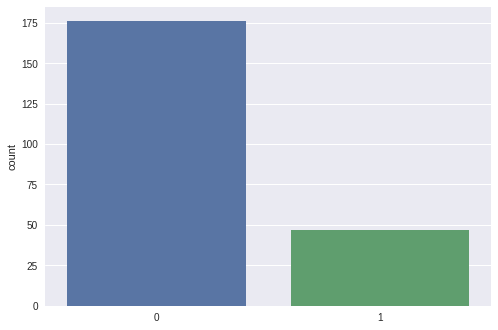

In [ ]:
freq_dict = dict()
for data in dataset['train']:
    if (data['airline_sentiment'] in freq_dict): freq_dict[data['airline_sentiment']] += 1
    else: freq_dict[data['airline_sentiment']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['train']) - 1)

sns.countplot(x=dataset['train']['airline_sentiment'])
freq_dict

{0: 0.800520381613183, 1: 0.20121422376409367}

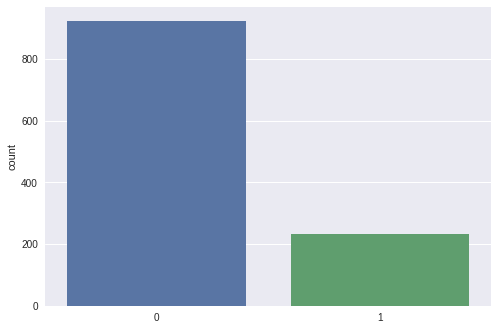

In [ ]:
freq_dict = dict()
for data in dataset['test']:
    if (data['airline_sentiment'] in freq_dict): freq_dict[data['airline_sentiment']] += 1
    else: freq_dict[data['airline_sentiment']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['test']) - 2)

sns.countplot(x=dataset['test']['airline_sentiment'])
freq_dict

In [ ]:
class Textual_EntailementClassifier(nn.Module):
    def __init__(self, input_dim, num_labels=3, dropout_rate=0.):
        super(Textual_EntailementClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(input_dim, input_dim // 3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(input_dim // 3, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        return self.linear2(x)

In [ ]:
class BERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(BERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.bert = BertModel(config=config) # Load pretrained Bert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
class ParsBERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(ParsBERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.parsbert = BertModel(config=config) # Load pretrained ParsBert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.parsbert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
MODEL_CLASSES = {
    'bert': (BertConfig, BERT_Textual_Entailement, BertTokenizer),
    'parsbert': (BertConfig, ParsBERT_Textual_Entailement, BertTokenizer),
}

MODEL_PATH_MAP = {
    # 'XLMRoberta': 'xlm-roberta-base',
    'bert': 'bert-base-uncased',
    'parsbert': 'HooshvareLab/bert-fa-zwnj-base',
}

logger = logging.getLogger(__name__)

In [ ]:
def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)

def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)
    
def label2index(label):
    if (label == 0): return 0
    elif (label == 1): return 1
    # else: return 2
    else: return label

def get_labels(dataset):
  train_label = list()
  for data in dataset:
      if (data['airline_sentiment'] != 'xx' and data['airline_sentiment'] != '-'): train_label.append(data['airline_sentiment'])
  
  return train_label

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def prepare_dataset(data, args, tokenizer, padding='max_length'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_label = torch.tensor([label2index(x['airline_sentiment']) for x in data if  (x['airline_sentiment'] != 'xx' and x['airline_sentiment'] != '-')], dtype=torch.long).to(device)
    bert_input = tokenizer([x['text'] for x in data if (x['airline_sentiment'] != 'xx' and x['airline_sentiment'] != '-')] , padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
    if ('token_type_ids' in bert_input):
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), bert_input['token_type_ids'].to(device), all_label)
    else:
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), torch.zeros_like(bert_input['input_ids']).to(device), all_label)

    return dataset

In [ ]:
#define
OUTPUT_DIM = 2
NUM_EPOCHS = 10
Prob_per_epoch = np.zeros((NUM_EPOCHS,len(dataset['train']),OUTPUT_DIM)) #2 labels

class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(dataset['train'])

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]
        self.config = self.config_class.from_pretrained(args.model_name_or_path, finetuning_task=args.task)
        self.model = self.model_class.from_pretrained(args.model_name_or_path,
                                                      config=self.config,
                                                      args=args,
                                                      label_lst=self.label_lst)
                                                      

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

    def train(self):
        # train_sampler = RandomSampler(self.train_dataset)
        train_sampler = SequentialSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)
        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()
        best_acc = -1
       
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")
        for epoch in train_iterator:
            label_preds = None
            out_label_ids = None
            # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
            stacked_train_preds = None
            for step, batch in enumerate(train_dataloader):
                self.model.train()
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                loss = outputs[0]
                label_logits = outputs[1]

                # ############## Extracting samples'probability ##############
                # # Get the preds
                preds = nn.Softmax(dim=1)(label_logits) # convert to probability


                # # Move preds to the CPU
                train_preds = preds.detach().cpu().numpy()
                
                if stacked_train_preds is None:  # first batch
                    stacked_train_preds = train_preds
                else:
                  stacked_train_preds = np.vstack((stacked_train_preds, train_preds))
                
                # #######################  END ############################

                 # label prediction
                if label_preds is None:
                    label_preds = label_logits.detach().cpu().numpy()
                    out_label_ids = inputs['label_ids'].detach().cpu().numpy()
                else:
                    label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                    out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)
                
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if(global_step % 10 == 0): logger.info("Train loss = %.4f", tr_loss / global_step)
                    if (self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0):
                        results = self.evaluate("dev")
                        if (float(results['accuracy']) > best_acc):
                        # if (float(results['slot_f1']) > best_f1):
                        #   best_f1 = float(results['slot_f1'])
                          best_acc = float(results['accuracy'])
                          logger.info("dev best_acc = %.4f", best_acc * 100.0)
                          self.save_model()

                   
            Prob_per_epoch[epoch][:,:] = stacked_train_preds
            
            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break
            
            # label result
            label_preds = np.argmax(label_preds, axis=1)
            logger.info("train_acc = %.4f", accuracy_score(out_label_ids, label_preds) * 100.0)


        return global_step, tr_loss / global_step

    def evaluate(self, mode):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("\n***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        label_preds = None
        out_label_ids = None

        self.model.eval()

        # for batch in tqdm(eval_dataloader, desc="Evaluating"):
        for batch in eval_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                tmp_eval_loss, label_logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
            
            nb_eval_steps += 1

            # label prediction
            if label_preds is None:
                label_preds = label_logits.detach().cpu().numpy()
                out_label_ids = inputs['label_ids'].detach().cpu().numpy()
            else:
                label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)


        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # label result
        label_preds = np.argmax(label_preds, axis=1)
        print(set(label_preds))
        total_result = accuracy_score(out_label_ids, label_preds)
        results.update({'accuracy' : total_result})
        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %.4f", key if key != 'loss' else 'loss', float(results[key]) * 100.0 if key != 'loss' else float(results[key]))

        if (mode == 'test'): print(classification_report(out_label_ids, label_preds, target_names=['negative', 'positive'], digits = 4))
        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)


    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir,
                                                          args=self.args,
                                                          label_lst=self.label_lst)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")


In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

Using bert


In [ ]:
args = dotdict(dict())
args.seed = 810197502
args.model_type = 'bert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.dropout_rate =  0.3
args.do_train = True
args.do_eval = True
args.train_batch_size = 32 
args.max_steps = -1
args.task = 'Paraphrase' 
args.no_cuda = False
args.weight_decay = 0
args.num_train_epochs = NUM_EPOCHS
args.gradient_accumulation_steps = 1
args.learning_rate = 3e-5 
args.adam_epsilon = 1e-8
args.warmup_steps = 0 
args.logging_steps = 200
args.save_steps = 500
args.max_grad_norm = 1
args.eval_batch_size = 64
args.model_dir = "Paraphrase_model_" + args.model_type
args.max_seq_len = 128


In [ ]:
init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
train_dataset = prepare_dataset(dataset['train'], args, tokenizer)
valid_dataset = prepare_dataset(dataset['validation'], args, tokenizer)
test_dataset = prepare_dataset(dataset['test'], args, tokenizer)
#valid_dataset = test_dataset

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BERT_Textual_Entailement: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BERT_Textual_Entailement were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# all
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/06/2022 23:47:52 - INFO - __main__ -   ***** Running training *****
08/06/2022 23:47:52 - INFO - __main__ -     Num examples = 8078
08/06/2022 23:47:52 - INFO - __main__ -     Num Epochs = 10
08/06/2022 23:47:52 - INFO - __main__ -     Total train batch size = 32
08/06/2022 23:47:52 - INFO - __main__ -     Gradient Accumulation steps = 1
08/06/2022 23:47:52 - INFO - __main__ -     Total optimization steps = 2530
08/06/2022 23:47:52 - INFO - __main__ -     Logging steps = 200
08/06/2022 23:47:52 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/06/2022 23:48:01 - INFO - __main__ -   Train loss = 0.6292
08/06/2022 23:48:07 - INFO - __main__ -  

{0, 1}


08/06/2022 23:50:30 - INFO - __main__ -   Train loss = 0.2520
08/06/2022 23:50:37 - INFO - __main__ -   Train loss = 0.2483
08/06/2022 23:50:43 - INFO - __main__ -   Train loss = 0.2439
08/06/2022 23:50:50 - INFO - __main__ -   Train loss = 0.2387
08/06/2022 23:50:57 - INFO - __main__ -   Train loss = 0.2343
08/06/2022 23:50:59 - INFO - __main__ -   train_acc = 91.7678
Epoch:  10%|█         | 1/10 [03:06<27:59, 186.56s/it]08/06/2022 23:51:03 - INFO - __main__ -   Train loss = 0.2322
08/06/2022 23:51:10 - INFO - __main__ -   Train loss = 0.2283
08/06/2022 23:51:17 - INFO - __main__ -   Train loss = 0.2249
08/06/2022 23:51:23 - INFO - __main__ -   Train loss = 0.2197
08/06/2022 23:51:30 - INFO - __main__ -   Train loss = 0.2156
08/06/2022 23:51:37 - INFO - __main__ -   Train loss = 0.2142
08/06/2022 23:51:43 - INFO - __main__ -   Train loss = 0.2120
08/06/2022 23:51:50 - INFO - __main__ -   Train loss = 0.2077
08/06/2022 23:51:57 - INFO - __main__ -   Train loss = 0.2068
08/06/2022 23:52

{0, 1}


08/06/2022 23:53:01 - INFO - __main__ -   Train loss = 0.1895
08/06/2022 23:53:08 - INFO - __main__ -   Train loss = 0.1875
08/06/2022 23:53:14 - INFO - __main__ -   Train loss = 0.1864
08/06/2022 23:53:21 - INFO - __main__ -   Train loss = 0.1845
08/06/2022 23:53:28 - INFO - __main__ -   Train loss = 0.1818
08/06/2022 23:53:35 - INFO - __main__ -   Train loss = 0.1790
08/06/2022 23:53:41 - INFO - __main__ -   Train loss = 0.1797
08/06/2022 23:53:48 - INFO - __main__ -   Train loss = 0.1774
08/06/2022 23:53:55 - INFO - __main__ -   Train loss = 0.1747
08/06/2022 23:54:02 - INFO - __main__ -   Train loss = 0.1721
08/06/2022 23:54:05 - INFO - __main__ -   train_acc = 96.5586
Epoch:  20%|██        | 2/10 [06:13<24:53, 186.63s/it]08/06/2022 23:54:08 - INFO - __main__ -   Train loss = 0.1708
08/06/2022 23:54:15 - INFO - __main__ -   Train loss = 0.1682
08/06/2022 23:54:21 - INFO - __main__ -   Train loss = 0.1661
08/06/2022 23:54:28 - INFO - __main__ -   Train loss = 0.1641
08/06/2022 23:54

{0, 1}


08/06/2022 23:55:36 - INFO - __main__ -   Train loss = 0.1540
08/06/2022 23:55:42 - INFO - __main__ -   Train loss = 0.1520
08/06/2022 23:55:49 - INFO - __main__ -   Train loss = 0.1507
08/06/2022 23:55:56 - INFO - __main__ -   Train loss = 0.1487
08/06/2022 23:56:02 - INFO - __main__ -   Train loss = 0.1477
08/06/2022 23:56:09 - INFO - __main__ -   Train loss = 0.1466
08/06/2022 23:56:16 - INFO - __main__ -   Train loss = 0.1454
08/06/2022 23:56:22 - INFO - __main__ -   Train loss = 0.1446
08/06/2022 23:56:29 - INFO - __main__ -   Train loss = 0.1437
08/06/2022 23:56:36 - INFO - __main__ -   Train loss = 0.1421
08/06/2022 23:56:43 - INFO - __main__ -   Train loss = 0.1403
08/06/2022 23:56:49 - INFO - __main__ -   Train loss = 0.1403
08/06/2022 23:56:56 - INFO - __main__ -   Train loss = 0.1387
08/06/2022 23:57:03 - INFO - __main__ -   Train loss = 0.1369
08/06/2022 23:57:09 - INFO - __main__ -   Train loss = 0.1353
08/06/2022 23:57:15 - INFO - __main__ -   train_acc = 98.4526
Epoch:  

{0, 1}


08/06/2022 23:58:07 - INFO - __main__ -   Train loss = 0.1274
08/06/2022 23:58:13 - INFO - __main__ -   Train loss = 0.1273
08/06/2022 23:58:20 - INFO - __main__ -   Train loss = 0.1262
08/06/2022 23:58:27 - INFO - __main__ -   Train loss = 0.1249
08/06/2022 23:58:33 - INFO - __main__ -   Train loss = 0.1244
08/06/2022 23:58:40 - INFO - __main__ -   Train loss = 0.1232
08/06/2022 23:58:47 - INFO - __main__ -   Train loss = 0.1222
08/06/2022 23:58:53 - INFO - __main__ -   Train loss = 0.1211
08/06/2022 23:59:00 - INFO - __main__ -   Train loss = 0.1200
08/06/2022 23:59:07 - INFO - __main__ -   Train loss = 0.1193
08/06/2022 23:59:13 - INFO - __main__ -   Train loss = 0.1184
08/06/2022 23:59:20 - INFO - __main__ -   Train loss = 0.1174
08/06/2022 23:59:27 - INFO - __main__ -   Train loss = 0.1165
08/06/2022 23:59:33 - INFO - __main__ -   Train loss = 0.1161
08/06/2022 23:59:40 - INFO - __main__ -   Train loss = 0.1154
08/06/2022 23:59:47 - INFO - __main__ -   Train loss = 0.1143
08/06/20

{0, 1}


08/07/2022 00:00:38 - INFO - __main__ -   Train loss = 0.1098
08/07/2022 00:00:39 - INFO - __main__ -   train_acc = 99.2201
Epoch:  40%|████      | 4/10 [12:46<19:25, 194.28s/it]08/07/2022 00:00:44 - INFO - __main__ -   Train loss = 0.1089
08/07/2022 00:00:51 - INFO - __main__ -   Train loss = 0.1079
08/07/2022 00:00:57 - INFO - __main__ -   Train loss = 0.1072
08/07/2022 00:01:04 - INFO - __main__ -   Train loss = 0.1062
08/07/2022 00:01:11 - INFO - __main__ -   Train loss = 0.1052
08/07/2022 00:01:18 - INFO - __main__ -   Train loss = 0.1049
08/07/2022 00:01:24 - INFO - __main__ -   Train loss = 0.1044
08/07/2022 00:01:31 - INFO - __main__ -   Train loss = 0.1035
08/07/2022 00:01:38 - INFO - __main__ -   Train loss = 0.1029
08/07/2022 00:01:44 - INFO - __main__ -   Train loss = 0.1020
08/07/2022 00:01:51 - INFO - __main__ -   Train loss = 0.1013
08/07/2022 00:01:58 - INFO - __main__ -   Train loss = 0.1007
08/07/2022 00:02:04 - INFO - __main__ -   Train loss = 0.0999
08/07/2022 00:02

{0, 1}


08/07/2022 00:03:12 - INFO - __main__ -   Train loss = 0.0957
08/07/2022 00:03:19 - INFO - __main__ -   Train loss = 0.0949
08/07/2022 00:03:25 - INFO - __main__ -   Train loss = 0.0946
08/07/2022 00:03:32 - INFO - __main__ -   Train loss = 0.0940
08/07/2022 00:03:39 - INFO - __main__ -   Train loss = 0.0934
08/07/2022 00:03:46 - INFO - __main__ -   Train loss = 0.0927
08/07/2022 00:03:49 - INFO - __main__ -   train_acc = 99.5667
Epoch:  50%|█████     | 5/10 [15:56<16:03, 192.67s/it]08/07/2022 00:03:52 - INFO - __main__ -   Train loss = 0.0921
08/07/2022 00:03:59 - INFO - __main__ -   Train loss = 0.0915
08/07/2022 00:04:05 - INFO - __main__ -   Train loss = 0.0909
08/07/2022 00:04:12 - INFO - __main__ -   Train loss = 0.0903
08/07/2022 00:04:19 - INFO - __main__ -   Train loss = 0.0898
08/07/2022 00:04:25 - INFO - __main__ -   Train loss = 0.0892
08/07/2022 00:04:32 - INFO - __main__ -   Train loss = 0.0892
08/07/2022 00:04:39 - INFO - __main__ -   Train loss = 0.0886
08/07/2022 00:04

{0, 1}


08/07/2022 00:05:43 - INFO - __main__ -   Train loss = 0.0847
08/07/2022 00:05:50 - INFO - __main__ -   Train loss = 0.0841
08/07/2022 00:05:56 - INFO - __main__ -   Train loss = 0.0837
08/07/2022 00:06:03 - INFO - __main__ -   Train loss = 0.0834
08/07/2022 00:06:10 - INFO - __main__ -   Train loss = 0.0831
08/07/2022 00:06:16 - INFO - __main__ -   Train loss = 0.0827
08/07/2022 00:06:23 - INFO - __main__ -   Train loss = 0.0821
08/07/2022 00:06:30 - INFO - __main__ -   Train loss = 0.0819
08/07/2022 00:06:36 - INFO - __main__ -   Train loss = 0.0813
08/07/2022 00:06:43 - INFO - __main__ -   Train loss = 0.0808
08/07/2022 00:06:50 - INFO - __main__ -   Train loss = 0.0803
08/07/2022 00:06:55 - INFO - __main__ -   train_acc = 99.6905
Epoch:  60%|██████    | 6/10 [19:02<12:41, 190.49s/it]08/07/2022 00:06:56 - INFO - __main__ -   Train loss = 0.0798
08/07/2022 00:07:03 - INFO - __main__ -   Train loss = 0.0792
08/07/2022 00:07:10 - INFO - __main__ -   Train loss = 0.0787
08/07/2022 00:07

{0, 1}


08/07/2022 00:08:14 - INFO - __main__ -   Train loss = 0.0761
08/07/2022 00:08:21 - INFO - __main__ -   Train loss = 0.0756
08/07/2022 00:08:27 - INFO - __main__ -   Train loss = 0.0752
08/07/2022 00:08:34 - INFO - __main__ -   Train loss = 0.0748
08/07/2022 00:08:41 - INFO - __main__ -   Train loss = 0.0744
08/07/2022 00:08:47 - INFO - __main__ -   Train loss = 0.0739
08/07/2022 00:08:54 - INFO - __main__ -   Train loss = 0.0735
08/07/2022 00:09:01 - INFO - __main__ -   Train loss = 0.0732
08/07/2022 00:09:07 - INFO - __main__ -   Train loss = 0.0729
08/07/2022 00:09:14 - INFO - __main__ -   Train loss = 0.0727
08/07/2022 00:09:21 - INFO - __main__ -   Train loss = 0.0724
08/07/2022 00:09:27 - INFO - __main__ -   Train loss = 0.0720
08/07/2022 00:09:34 - INFO - __main__ -   Train loss = 0.0717
08/07/2022 00:09:41 - INFO - __main__ -   Train loss = 0.0713
08/07/2022 00:09:47 - INFO - __main__ -   Train loss = 0.0709
08/07/2022 00:09:54 - INFO - __main__ -   Train loss = 0.0705
08/07/20

{0, 1}


08/07/2022 00:10:48 - INFO - __main__ -   Train loss = 0.0687
08/07/2022 00:10:55 - INFO - __main__ -   Train loss = 0.0683
08/07/2022 00:11:01 - INFO - __main__ -   Train loss = 0.0681
08/07/2022 00:11:08 - INFO - __main__ -   Train loss = 0.0678
08/07/2022 00:11:15 - INFO - __main__ -   Train loss = 0.0675
08/07/2022 00:11:21 - INFO - __main__ -   Train loss = 0.0672
08/07/2022 00:11:28 - INFO - __main__ -   Train loss = 0.0668
08/07/2022 00:11:35 - INFO - __main__ -   Train loss = 0.0665
08/07/2022 00:11:42 - INFO - __main__ -   Train loss = 0.0662
08/07/2022 00:11:48 - INFO - __main__ -   Train loss = 0.0658
08/07/2022 00:11:55 - INFO - __main__ -   Train loss = 0.0655
08/07/2022 00:12:02 - INFO - __main__ -   Train loss = 0.0652
08/07/2022 00:12:08 - INFO - __main__ -   Train loss = 0.0649
08/07/2022 00:12:15 - INFO - __main__ -   Train loss = 0.0646
08/07/2022 00:12:22 - INFO - __main__ -   Train loss = 0.0644
08/07/2022 00:12:28 - INFO - __main__ -   Train loss = 0.0642
08/07/20

{0, 1}


08/07/2022 00:13:19 - INFO - __main__ -   Train loss = 0.0627
08/07/2022 00:13:26 - INFO - __main__ -   Train loss = 0.0624
08/07/2022 00:13:28 - INFO - __main__ -   train_acc = 99.8391
Epoch:  80%|████████  | 8/10 [25:36<06:29, 194.85s/it]08/07/2022 00:13:32 - INFO - __main__ -   Train loss = 0.0621
08/07/2022 00:13:39 - INFO - __main__ -   Train loss = 0.0618
08/07/2022 00:13:46 - INFO - __main__ -   Train loss = 0.0615
08/07/2022 00:13:52 - INFO - __main__ -   Train loss = 0.0612
08/07/2022 00:13:59 - INFO - __main__ -   Train loss = 0.0609
08/07/2022 00:14:06 - INFO - __main__ -   Train loss = 0.0606
08/07/2022 00:14:12 - INFO - __main__ -   Train loss = 0.0604
08/07/2022 00:14:19 - INFO - __main__ -   Train loss = 0.0603
08/07/2022 00:14:26 - INFO - __main__ -   Train loss = 0.0601
08/07/2022 00:14:32 - INFO - __main__ -   Train loss = 0.0598
08/07/2022 00:14:39 - INFO - __main__ -   Train loss = 0.0595
08/07/2022 00:14:46 - INFO - __main__ -   Train loss = 0.0592
08/07/2022 00:14

{0, 1}


08/07/2022 00:15:50 - INFO - __main__ -   Train loss = 0.0575
08/07/2022 00:15:57 - INFO - __main__ -   Train loss = 0.0572
08/07/2022 00:16:04 - INFO - __main__ -   Train loss = 0.0570
08/07/2022 00:16:10 - INFO - __main__ -   Train loss = 0.0567
08/07/2022 00:16:17 - INFO - __main__ -   Train loss = 0.0565
08/07/2022 00:16:24 - INFO - __main__ -   Train loss = 0.0562
08/07/2022 00:16:30 - INFO - __main__ -   Train loss = 0.0560
08/07/2022 00:16:35 - INFO - __main__ -   train_acc = 99.9133
Epoch:  90%|█████████ | 9/10 [28:42<03:12, 192.18s/it]08/07/2022 00:16:37 - INFO - __main__ -   Train loss = 0.0557
08/07/2022 00:16:43 - INFO - __main__ -   Train loss = 0.0555
08/07/2022 00:16:50 - INFO - __main__ -   Train loss = 0.0553
08/07/2022 00:16:57 - INFO - __main__ -   Train loss = 0.0550
08/07/2022 00:17:03 - INFO - __main__ -   Train loss = 0.0548
08/07/2022 00:17:10 - INFO - __main__ -   Train loss = 0.0546
08/07/2022 00:17:17 - INFO - __main__ -   Train loss = 0.0544
08/07/2022 00:17

{0, 1}


08/07/2022 00:18:24 - INFO - __main__ -   Train loss = 0.0529
08/07/2022 00:18:31 - INFO - __main__ -   Train loss = 0.0527
08/07/2022 00:18:37 - INFO - __main__ -   Train loss = 0.0525
08/07/2022 00:18:44 - INFO - __main__ -   Train loss = 0.0523
08/07/2022 00:18:51 - INFO - __main__ -   Train loss = 0.0521
08/07/2022 00:18:58 - INFO - __main__ -   Train loss = 0.0519
08/07/2022 00:19:04 - INFO - __main__ -   Train loss = 0.0517
08/07/2022 00:19:11 - INFO - __main__ -   Train loss = 0.0515
08/07/2022 00:19:18 - INFO - __main__ -   Train loss = 0.0513
08/07/2022 00:19:24 - INFO - __main__ -   Train loss = 0.0511
08/07/2022 00:19:31 - INFO - __main__ -   Train loss = 0.0509
08/07/2022 00:19:38 - INFO - __main__ -   Train loss = 0.0507
08/07/2022 00:19:44 - INFO - __main__ -   Train loss = 0.0505
08/07/2022 00:19:44 - INFO - __main__ -   train_acc = 99.9381
Epoch: 100%|██████████| 10/10 [31:52<00:00, 191.21s/it]
08/07/2022 00:19:44 - INFO - __main__ -   
***** Running evaluation on test 

{0, 1}
              precision    recall  f1-score   support

    negative     0.9707    0.9697    0.9702       923
    positive     0.8798    0.8836    0.8817       232

    accuracy                         0.9524      1155
   macro avg     0.9253    0.9266    0.9260      1155
weighted avg     0.9525    0.9524    0.9524      1155



In [ ]:
# random
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/07/2022 17:08:59 - INFO - __main__ -   ***** Running training *****
08/07/2022 17:08:59 - INFO - __main__ -     Num examples = 223
08/07/2022 17:08:59 - INFO - __main__ -     Num Epochs = 10
08/07/2022 17:08:59 - INFO - __main__ -     Total train batch size = 32
08/07/2022 17:08:59 - INFO - __main__ -     Gradient Accumulation steps = 1
08/07/2022 17:08:59 - INFO - __main__ -     Total optimization steps = 70
08/07/2022 17:08:59 - INFO - __main__ -     Logging steps = 200
08/07/2022 17:08:59 - INFO - __main__ -     Save steps = 500
Epoch:  10%|█         | 1/10 [00:04<00:40,  4.47s/it]08/07/2022 17:09:05 - INFO - __main__ -   Train loss = 0.6318
08/07/2022 17:09:08 - INFO - __main_

{0, 1}
              precision    recall  f1-score   support

    negative     0.9545    0.9101    0.9318       923
    positive     0.6982    0.8276    0.7574       232

    accuracy                         0.8935      1155
   macro avg     0.8264    0.8688    0.8446      1155
weighted avg     0.9031    0.8935    0.8968      1155



In [ ]:
# forgetable
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/07/2022 16:54:49 - INFO - __main__ -   ***** Running training *****
08/07/2022 16:54:49 - INFO - __main__ -     Num examples = 223
08/07/2022 16:54:49 - INFO - __main__ -     Num Epochs = 10
08/07/2022 16:54:49 - INFO - __main__ -     Total train batch size = 32
08/07/2022 16:54:49 - INFO - __main__ -     Gradient Accumulation steps = 1
08/07/2022 16:54:49 - INFO - __main__ -     Total optimization steps = 70
08/07/2022 16:54:49 - INFO - __main__ -     Logging steps = 200
08/07/2022 16:54:49 - INFO - __main__ -     Save steps = 500
Epoch:  10%|█         | 1/10 [00:06<01:02,  6.90s/it]08/07/2022 16:54:57 - INFO - __main__ -   Train loss = 0.6934
08/07/2022 16:55:00 - INFO - __main_

{0, 1}
              precision    recall  f1-score   support

    negative     0.9110    0.7432    0.8186       923
    positive     0.4104    0.7112    0.5205       232

    accuracy                         0.7368      1155
   macro avg     0.6607    0.7272    0.6696      1155
weighted avg     0.8105    0.7368    0.7587      1155



In [ ]:
Prob_per_epoch.shape

(10, 8078, 2)

In [ ]:
import pickle
with open(f'Sentiment_prob_per_{NUM_EPOCHS}epochs.pkl', 'wb') as f:
    data = pickle.dump(Prob_per_epoch, f)

In [ ]:
# # Save the model to drive
# !cp /content/Textual_Entailement_model/pytorch_model.bin /content/drive/MyDrive/Textual_Entailement_model
# !cp /content/Textual_Entailement_model/config.json /content/drive/MyDrive/Textual_Entailement_model